# Random Forest Model

## Intro

Given the size of the dataset ($243 \times 15$), building a random forest would probably be an overkill. Nontheless, we are just curious how the performance would differ when compared to the Logistic Regression model.

Because random forest is based on bootstrap aggregating decision trees, we don't need to check any statistical features on our data since we are not making any mathematical assumptions. The only thing that need to be done further on the data is to encode all the categorical variables. The Random Forest Classifier in sklearn cannot recognize string typed categorical variables in default, thus we need to encode them into ${0,1}$ integers.

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## GLOBAL VARIABLES

# GRIDSEARCH default = False. Change to True to run GridSearchCV again.
GRIDSEARCH = False

In [2]:
# Load and further clean data
data = pd.read_csv("data/Algerian_forest_fires_dataset_CLEANED.csv")
# Drop the first messy column
data = data.drop(["Unnamed: 0"], axis=1)

## Process Data

Given that our dataset is small, I decided to reserve $1/3$ of the data as testing. We don't want to reserve too much, otherwise random forest might perform badly on a very small traning dataset. This is because bootstrap sampling on small datasets might result in many repeated samples.

In [3]:
# Define X, y
y = data["Classes"]
X = data.drop("Classes", axis=1)
# Random forest have trouble with string, so one hot encode:
# "Bejaia" -> 0, "Sidi-Bel Abbes" -> 1
# "notfire" -> 0, "fire" ->1
X["Region"][X["Region"] == "Bejaia"] = 0
X["Region"][X["Region"] == "Sidi-Bel Abbes"] = 1
y[y == "notfire"] = 0
y[y == "fire"] = 1
y = y.astype(int)
# Train test split on 1/3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Hyperparameter Tuning

Perform Grid Search Cross Validation on the random forest model. The algorithm search through different values for hyperparameters and perform cross validation on each combination. Given the small dataset, I decided to search through the number of trees between the range $[1,100]$ and the maximum depth between $[1,5]$. The algorithm will perform $10$-Fold corss validation on each combination of hyperparameters.

In [4]:
## Grid search cross validation
if GRIDSEARCH :
    # Define param_grid
    param_grid = {"n_estimators" : (10**np.linspace(0, 2, 40)).astype(int),
              "max_depth" : [1,2,3,4,5]}
    # Define random forest model
    rf_model = RandomForestClassifier(random_state=42)
    # Grid search cross validation
    grid = GridSearchCV(rf_model, param_grid, scoring="recall", cv=10)
    grid.fit(X_train, y_train)
    
    # Print best result
    print(grid.best_params_, grid.best_score_)
    
    # Save grid search model
    joblib.dump(grid, 'models/random_forest_gridcv.pkl')
else :
    if os.path.exists("models/random_forest_gridcv.pkl") :
        grid = joblib.load("models/random_forest_gridcv.pkl")
        print("Successfully loaded pre-trained model.")
    else :
        print("The pre-trained model does not exist. Please change GRIDSEARCH to true.")

Successfully loaded pre-trained model.


### Selecting the Metric for Evaluation

I chose to evaluate on the **recall** (or **true positive rate**) for each model during cross validation. This is because, as a model predicting forest fires, we really don't want to predict no fire when there is actually fire. Therefore, we want to penalize **false negatives** (predicting no fire wrongly). Recall does exactly this job.

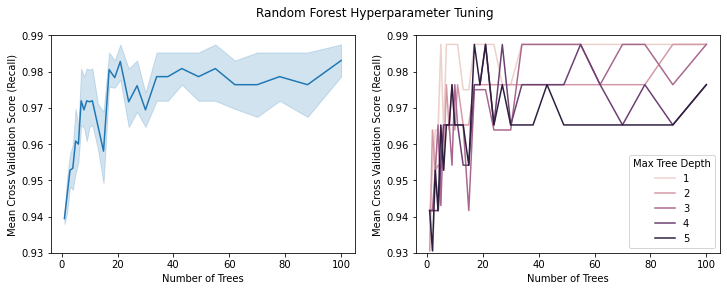

In [5]:
# Plot CV results
cv_results = pd.DataFrame(grid.cv_results_)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot("param_n_estimators", "mean_test_score", data=cv_results, ax = axs[0])
sns.lineplot("param_n_estimators", "mean_test_score", data=cv_results, hue = "param_max_depth", ax = axs[1])
plt.suptitle("Random Forest Hyperparameter Tuning")
for ax in axs:
    ax.set(xlabel="Number of Trees", ylabel="Mean Cross Validation Score (Recall)", ylim=(0.93, 0.99))
axs[1].legend(title="Max Tree Depth")

plt.savefig("figures/random_forest.png")

### Interpretating the Result

The figures above display the results of cross validation. Observing the left figure we see that the cross validated recall (true positive rate) stablizes when there are more than $35$ trees being grown. On the right figure, we see that the tree with maximum depth of one is actually the best performing model overall. We can observe that when the number of trees is larger than $35$, the tree with depth one is consistently performing the best. Thus, based on the cross validation result, the best performing model have $38$ trees with maximum depth of $1$.

In [6]:
# Save best random forest
final_model = RandomForestClassifier(n_estimators=38, max_depth=1, random_state=42)
final_model.fit(X_train, y_train)
joblib.dump(final_model, 'models/random_forest.pkl')

['models/random_forest.pkl']

In [7]:
# Features never used:
X.columns[final_model.feature_importances_ == 0]

Index(['day', 'month', 'year', 'RH', 'Ws', 'Region'], dtype='object')

In [8]:
# Most important feature
X.columns[np.argmax(final_model.feature_importances_)]

'ISI'

## Further Exploration

By looking into our final random forest model, we see that 'day', 'month', 'year', 'RH', 'Ws', and 'Region' are never being used as a condition to perform a split. We can also see that the most important feature that the random forest based on is tne 'ISI' (Initial Spread Index). 